### Performance Attribution based on Shapley algorithm

In [1]:
from model_builder import model_builder
from data_gen_shapley import simulate_private_equity_cashflows_shapley
import numpy as np
import random
from pme_calc import moic, xirr
import pandas as pd

In [2]:
cashflows = simulate_private_equity_cashflows_shapley()

In [3]:
# Normalize the cashflows of each fund in the market

def fund_weights(cashflows):
    funds = cashflows['FundID'].unique() 
    weights = {}
    for fund in funds:
        fund_cashflows = cashflows[cashflows['FundID'] == fund]
        weights[fund] = -fund_cashflows['Cashflow'].sum()
    return weights

cashflows_contr = cashflows[cashflows['Cashflow'] < 0]
eq_cashflows_contr = fund_weights(cashflows_contr)

def eq_calc(row):
    fund = row['FundID']
    cf = row['Cashflow']
    
    return cf / eq_cashflows_contr[fund]

# Apply the function row-wise
cashflows['eq_cashflow'] = cashflows.apply(eq_calc, axis=1)

# Drop and rename
cashflows = cashflows.drop(columns=['Cashflow']).rename(columns={'eq_cashflow': 'Cashflow'})

cashflows


,FundID,VintageYear,Strategy,Geography,FundQuality,Quarter,date,Cashflow
0,0,1990,Venture,Rest of World,Bad,0,1990-03-31,-0.229863
1,0,1990,Venture,Rest of World,Bad,1,1990-06-30,0.000000
2,0,1990,Venture,Rest of World,Bad,2,1990-09-30,-0.134382
3,0,1990,Venture,Rest of World,Bad,3,1990-12-31,0.000000
4,0,1990,Venture,Rest of World,Bad,4,1991-03-31,-0.117993
...,...,...,...,...,...,...,...,...
118598,2399,1999,Buyout,Rest of World,Bad,43,2009-12-31,0.090851
118599,2399,1999,Buyout,Rest of World,Bad,44,2010-03-31,0.036162
118600,2399,1999,Buyout,Rest of World,Bad,45,2010-06-30,0.000000
118601,2399,1999,Buyout,Rest of World,Bad,46,2010-09-30,0.000000


In [4]:
attributions = []
vintages = cashflows['VintageYear'].unique()
strategies = cashflows['Strategy'].unique()
geos = cashflows['Geography'].unique()

for vintage in vintages:
    for strategy in strategies:
        for geo in geos:
            attributions.append((vintage, strategy, geo))

In [5]:
def permute_list(input_list):
    output_list = input_list.copy()  
    random.shuffle(output_list)
    return output_list

In [6]:
def attribution_irr_changes(attributions, cashflows):
    attribution_values = []

    # Handle the first attribution separately
    first_df = cashflows[
        (cashflows['VintageYear'] == attributions[0][0]) &
        (cashflows['Strategy'] == attributions[0][1]) &
        (cashflows['Geography'] == attributions[0][2])
    ]
    first_aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
    first_attribution_irr = xirr(first_aggregated_df['date'], first_aggregated_df['Cashflow'])
    attribution_values.append(first_attribution_irr)

    # Iterate through the rest
    for attrib in attributions[1:]:
        df = cashflows[
            (cashflows['VintageYear'] == attrib[0]) &
            (cashflows['Strategy'] == attrib[1]) &
            (cashflows['Geography'] == attrib[2])
        ]
        first_df = pd.concat([first_df, df], ignore_index=True)  # Keep building the portfolio
        aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
        attribution_irr = xirr(aggregated_df['date'], aggregated_df['Cashflow'])
        attribution_values.append(attribution_irr)

    # Calculate incremental IRRs
    final_attribution_values = [attribution_values[0]]
    for i in range(1, len(attribution_values)):
        delta = attribution_values[i] - attribution_values[i-1]
        final_attribution_values.append(delta)

    # Build the output dict
    result = {attrib: value for attrib, value in zip(attributions, final_attribution_values)}
    
    return result


In [7]:
def attribution_moic_changes(attributions, cashflows):
    attribution_values = []

    # Handle the first attribution separately
    first_df = cashflows[
        (cashflows['VintageYear'] == attributions[0][0]) &
        (cashflows['Strategy'] == attributions[0][1]) &
        (cashflows['Geography'] == attributions[0][2])
    ]
    first_aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
    first_attribution_irr = moic(first_aggregated_df)
    attribution_values.append(first_attribution_irr)

    # Iterate through the rest
    for attrib in attributions[1:]:
        df = cashflows[
            (cashflows['VintageYear'] == attrib[0]) &
            (cashflows['Strategy'] == attrib[1]) &
            (cashflows['Geography'] == attrib[2])
        ]
        first_df = pd.concat([first_df, df], ignore_index=True)  # Keep building the portfolio
        aggregated_df = first_df.groupby('date', as_index=False)['Cashflow'].sum()
        attribution_irr = moic(aggregated_df)
        attribution_values.append(attribution_irr)

    # Calculate incremental IRRs
    final_attribution_values = [attribution_values[0]]
    for i in range(1, len(attribution_values)):
        delta = attribution_values[i] - attribution_values[i-1]
        final_attribution_values.append(delta)

    # Build the output dict
    result = {attrib: value for attrib, value in zip(attributions, final_attribution_values)}
    
    return result


In [8]:
def shapley_irr(permutated_attributions, cashflows):
    shapley_values = {}
    for attrib in permutated_attributions:
        irr_changes = attribution_irr_changes(attrib, cashflows)
        for key, value in irr_changes.items():
            if key in shapley_values:
                shapley_values[key] += value
            else:
                shapley_values[key] = value 

    average_results = {key: value / len(permutated_attributions) for key, value in shapley_values.items()}
    return average_results

In [9]:
def shapley_moic(permutated_attributions, cashflows):
    shapley_values = {}
    for attrib in permutated_attributions:
        moic_changes = attribution_moic_changes(attrib, cashflows)
        for key, value in moic_changes.items():
            if key in shapley_values:
                shapley_values[key] += value
            else:
                shapley_values[key] = value 

    average_results = {key: value / len(permutated_attributions) for key, value in shapley_values.items()}
    return average_results

### Attribution calculation

In [10]:
permutated_attributions_50 = []
permutated_attributions_100 = []
permutated_attributions_500 = []
permutated_attributions_1000 = []

# numb_of_permutations = 500 # Number of permutations to generate
# for i in range(numb_of_permutations):
#     permutated_attributions.append(permute_list(attributions))

for i in range(50):
    permutated_attributions_50.append(permute_list(attributions))
for i in range(100):
    permutated_attributions_100.append(permute_list(attributions))
for i in range(500):
    permutated_attributions_500.append(permute_list(attributions))
for i in range(1000):
    permutated_attributions_1000.append(permute_list(attributions))

In [11]:
shapley_irr_results_50 = shapley_irr(permutated_attributions_50, cashflows)
shapley_moic_results_50 = shapley_moic(permutated_attributions_50, cashflows)

In [12]:
shapley_irr_results_100 = shapley_irr(permutated_attributions_100, cashflows)
shapley_moic_results_100 = shapley_moic(permutated_attributions_100, cashflows)

In [168]:
shapley_irr_results_500 = shapley_irr(permutated_attributions_500, cashflows)
shapley_moic_results_500 = shapley_moic(permutated_attributions_500, cashflows)

In [169]:
shapley_irr_results_1000 = shapley_irr(permutated_attributions_1000, cashflows)
shapley_moic_results_1000 = shapley_moic(permutated_attributions_1000, cashflows)

### Portfolio testing

In [101]:
def portfolio_cashflows(cashflows, portfolio_size):
    
    selected_funds = np.random.choice(cashflows['FundID'].unique(), size=portfolio_size, replace=False)
    portfolio = cashflows[cashflows['FundID'].isin(selected_funds)]

    return portfolio

In [102]:
port_cfs = portfolio_cashflows(cashflows, 200)
port_cfs_contr = port_cfs[port_cfs['Cashflow'] < 0]

In [103]:
def calculate_attribution_weights(port_cfs_contr):
    # Group by the attribution dimensions
    grouped = port_cfs_contr.groupby(['VintageYear', 'Strategy', 'Geography'])['Cashflow'].sum()
    
    # Calculate total contributions
    total_contribution = grouped.sum()
    
    # Calculate weights
    weights = grouped / total_contribution
    
    # Convert back to DataFrame (optional, for easy viewing)
    weights_df = weights.reset_index().rename(columns={'Cashflow': 'Weight'})
    
    return weights_df

In [104]:
weight_df = calculate_attribution_weights(port_cfs_contr)

In [105]:
def weighted_attribution(weights_df, attribution_results):
    weighted_results = {}
    
    for _, row in weights_df.iterrows():
        key = (row['VintageYear'], row['Strategy'], row['Geography'])
        
        if key in attribution_results:
            weighted_value = row['Weight'] * attribution_results[key]
            weighted_results[key] = weighted_value
        else:
            # If some attribution is missing from results, assume 0
            weighted_results[key] = 0
    
    return weighted_results


In [106]:
port_result = weighted_attribution(weight_df, shapley_irr_results_50)

In [107]:
total_weighted_attribution = sum(port_result.values())
print(total_weighted_attribution*len(shapley_irr_results_50))

0.04782060416357527


In [108]:
port_aggregated_df = port_cfs.groupby('date', as_index=False)['Cashflow'].sum()
port_irr = xirr(port_aggregated_df['date'], port_aggregated_df['Cashflow'])

In [109]:
port_irr

0.07463047225320625

### Portfolio simulation for residuals

In [110]:
def shapley_simulation(cashflows, shapley_irr_results, type, num_simulations=10, portfolio_size=200):
    results = []
    
    for _ in range(num_simulations):
        # Generate a random portfolio
        portfolio = portfolio_cashflows(cashflows, portfolio_size)
        
        # Calculate the attribution weights for the portfolio
        weights_df = calculate_attribution_weights(portfolio[portfolio['Cashflow'] < 0])
        
        # Calculate the weighted attribution results
        weighted_results = weighted_attribution(weights_df, shapley_irr_results)
        # Calculate the portfolio return
        if type == 'irr':
            port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
            port_return = xirr(port_aggregated_df['date'], port_aggregated_df['Cashflow'])
        elif type == 'moic':
            port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
            port_return = moic(port_aggregated_df)
        
        # Store the results
        results.append([sum(weighted_results.values())*len(shapley_irr_results), port_return])
    
    return results

In [292]:
moic_result_50 = shapley_simulation(cashflows, shapley_moic_results_50, 'moic', num_simulations=1000, portfolio_size=200)
irr_result_50 = shapley_simulation(cashflows, shapley_irr_results_50, 'irr', num_simulations=1000, portfolio_size=200)

In [293]:
moic_result_100 = shapley_simulation(cashflows, shapley_moic_results_100, 'moic', num_simulations=1000, portfolio_size=200)
irr_result_100 = shapley_simulation(cashflows, shapley_irr_results_100, 'irr', num_simulations=1000, portfolio_size=200)

In [294]:
moic_result_500 = shapley_simulation(cashflows, shapley_moic_results_500, 'moic', num_simulations=1000, portfolio_size=200)
irr_result_500 = shapley_simulation(cashflows, shapley_irr_results_500, 'irr', num_simulations=1000, portfolio_size=200)

In [295]:
moic_result_1000 = shapley_simulation(cashflows, shapley_moic_results_1000, 'moic', num_simulations=1000, portfolio_size=200)
irr_result_1000 = shapley_simulation(cashflows, shapley_irr_results_1000, 'irr', num_simulations=1000, portfolio_size=200)

In [177]:
moic_residual_50 = [a - b for a, b in moic_result_50]
irr_residual_50 = [a - b for a, b in irr_result_50]

In [178]:
moic_residual_100 = [a - b for a, b in moic_result_100]
irr_residual_100 = [a - b for a, b in irr_result_100]

In [258]:
moic_residual_500 = [a - b for a, b in moic_result_500]
irr_residual_500 = [a - b for a, b in irr_result_500]
moic_residual_1000 = [a - b for a, b in moic_result_1000]
irr_residual_1000 = [a - b for a, b in irr_result_1000]

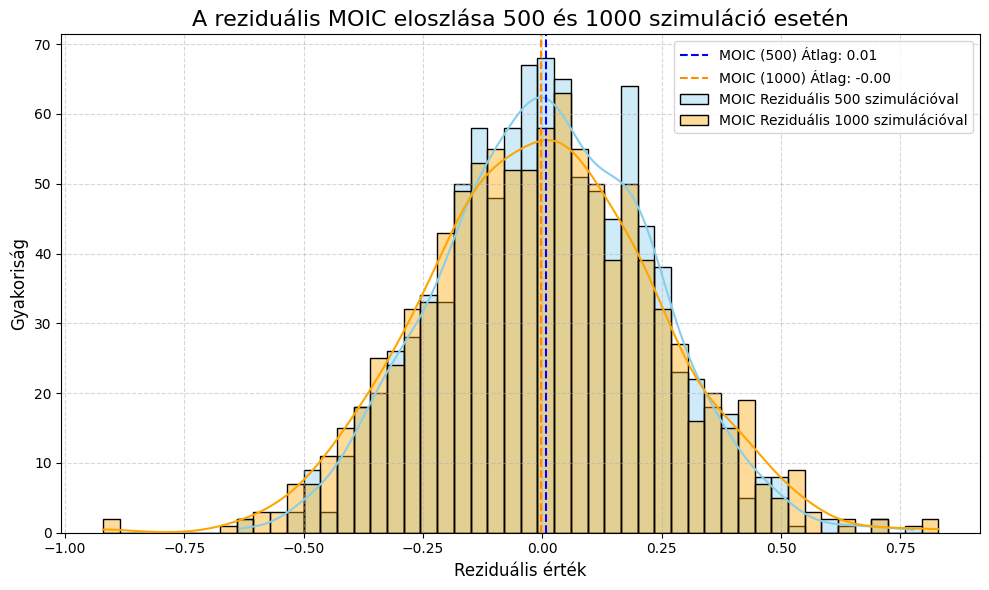

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume moic_residual_50 and moic_residual_100 are your lists
moic_array_50 = np.array(moic_residual_500)
moic_array_100 = np.array(moic_residual_1000)

# Determine common bin edges from combined range
combined = np.concatenate([moic_array_50, moic_array_100])
bins = np.histogram_bin_edges(combined, bins=50)

plt.figure(figsize=(10, 6))

# Plot MOIC histogram for 50 simulations
sns.histplot(moic_array_50, bins=bins, kde=True, color='skyblue', edgecolor='black',
             label='MOIC Reziduális 500 szimulációval', alpha=0.4)

# Plot MOIC histogram for 100 simulations
sns.histplot(moic_array_100, bins=bins, kde=True, color='orange', edgecolor='black',
             label='MOIC Reziduális 1000 szimulációval', alpha=0.4)

# Add vertical lines for means
plt.axvline(moic_array_50.mean(), color='blue', linestyle='--', linewidth=1.5,
            label=f'MOIC (500) Átlag: {moic_array_50.mean():.2f}')
plt.axvline(moic_array_100.mean(), color='darkorange', linestyle='--', linewidth=1.5,
            label=f'MOIC (1000) Átlag: {moic_array_100.mean():.2f}')

# Add titles and labels
plt.title('A reziduális MOIC eloszlása 500 és 1000 szimuláció esetén', fontsize=16)
plt.xlabel('Reziduális érték', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("moic_res_distr500.pdf", format='pdf', bbox_inches='tight')
plt.show()


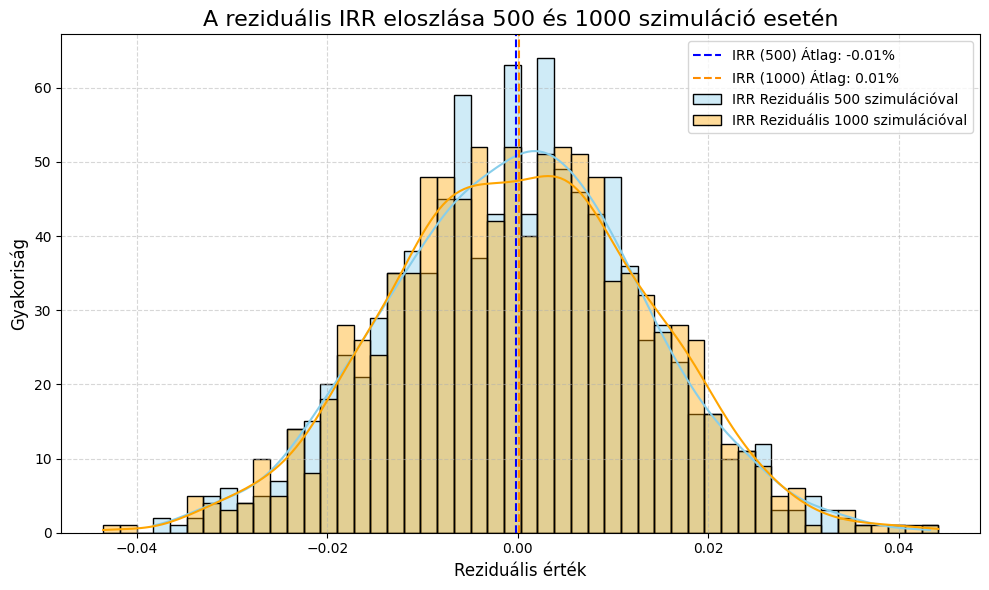

In [260]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assume moic_residual_50 and moic_residual_100 are your lists
moic_array_50 = np.array(irr_residual_500)
moic_array_100 = np.array(irr_residual_1000)

# Determine common bin edges from combined range
combined = np.concatenate([moic_array_50, moic_array_100])
bins = np.histogram_bin_edges(combined, bins=50)

plt.figure(figsize=(10, 6))

# Plot MOIC histogram for 50 simulations
sns.histplot(moic_array_50, bins=bins, kde=True, color='skyblue', edgecolor='black',
             label='IRR Reziduális 500 szimulációval', alpha=0.4)

# Plot MOIC histogram for 100 simulations
sns.histplot(moic_array_100, bins=bins, kde=True, color='orange', edgecolor='black',
             label='IRR Reziduális 1000 szimulációval', alpha=0.4)

# Add vertical lines for means
plt.axvline(moic_array_50.mean(), color='blue', linestyle='--', linewidth=1.5,
            label=f'IRR (500) Átlag: {moic_array_50.mean():.2%}')
plt.axvline(moic_array_100.mean(), color='darkorange', linestyle='--', linewidth=1.5,
            label=f'IRR (1000) Átlag: {moic_array_100.mean():.2%}')

# Add titles and labels
plt.title('A reziduális IRR eloszlása 500 és 1000 szimuláció esetén', fontsize=16)
plt.xlabel('Reziduális érték', fontsize=12)
plt.ylabel('Gyakoriság', fontsize=12)
plt.legend()

# Grid for better readability
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

plt.savefig("irr_res_distr500.pdf", format='pdf', bbox_inches='tight')
plt.show()


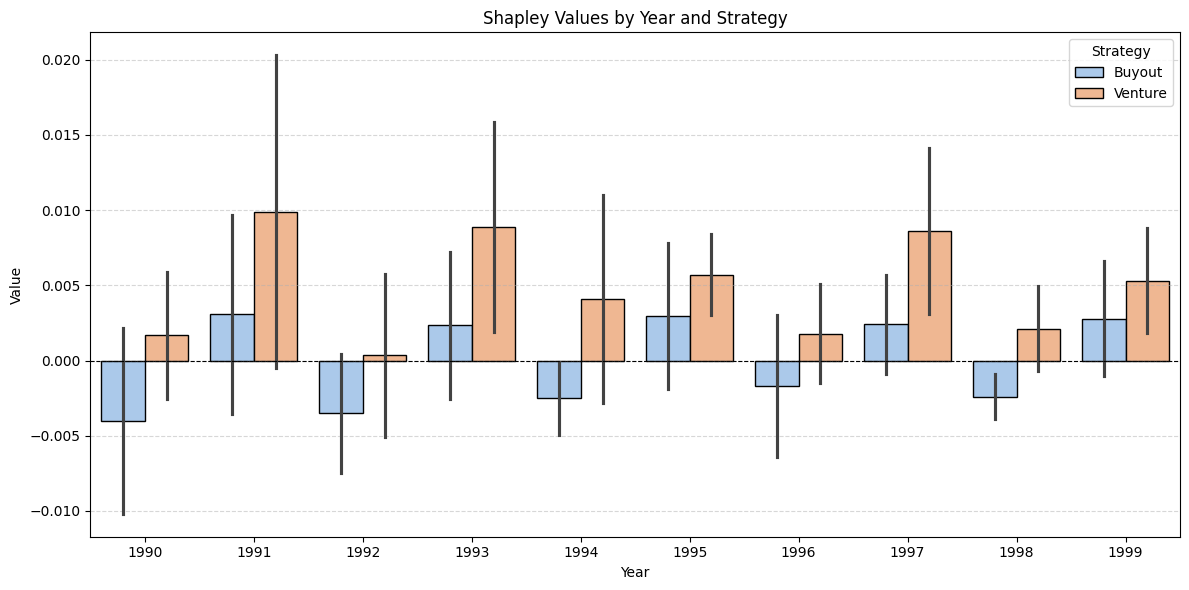

In [118]:
# attrribution returns
df = pd.DataFrame(
    [(year, strategy, geo, value) for (year, strategy, geo), value in shapley_irr_results_100.items()],
    columns=["Year", "Strategy", "Geography", "Value"]
)

# Optional: sort by year for better readability
df = df.sort_values("Year")

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df, x="Year", y="Value", hue="Strategy", palette="pastel", edgecolor='black')

plt.title("Shapley Values by Year and Strategy")
plt.xlabel("Year")
plt.ylabel("Value")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend(title="Strategy")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

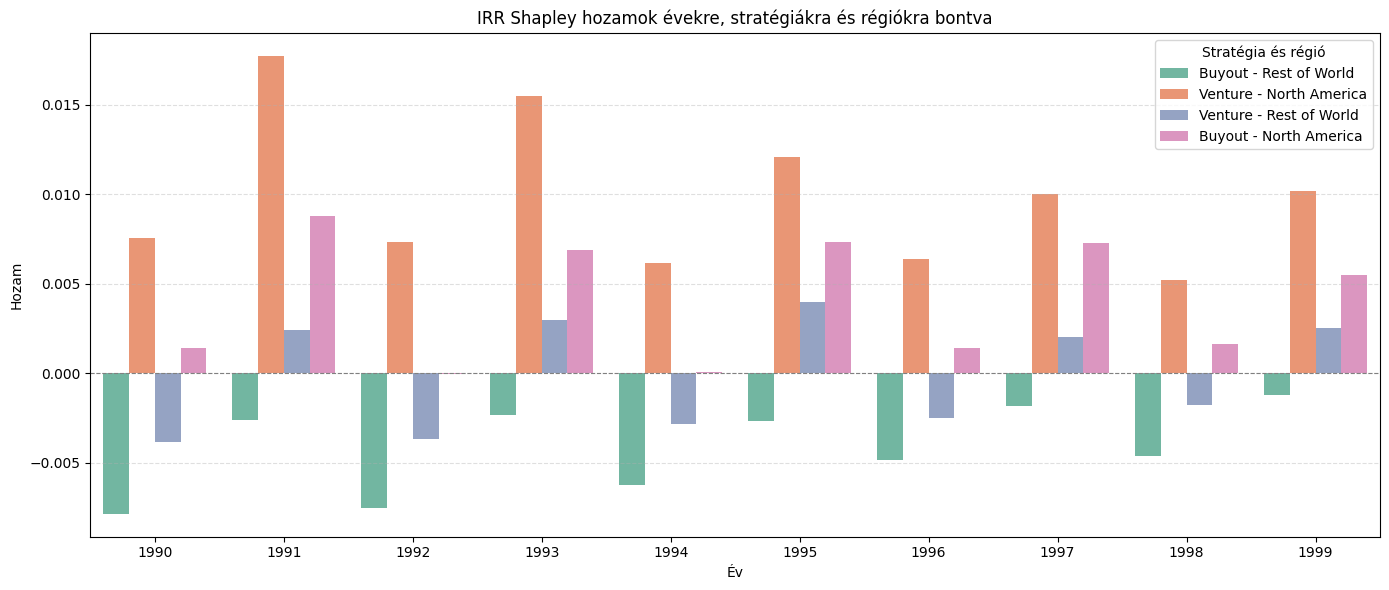

In [290]:
df = pd.DataFrame(
    [(year, strategy, geo, value) for (year, strategy, geo), value in shapley_irr_results_1000.items()],
    columns=["Year", "Strategy", "Geography", "Value"]
)

# Combine Strategy and Geography for clearer bar groups
df["Group"] = df["Strategy"] + " - " + df["Geography"]

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="Year", y="Value", hue="Group", palette="Set2")  # No edgecolor = no black lines

plt.title("IRR Shapley hozamok évekre, stratégiákra és régiókra bontva")
plt.xlabel("Év")
plt.ylabel("Hozam")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(title="Stratégia és régió")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("irr_shapley_ind.pdf", format='pdf', bbox_inches='tight')

plt.show()

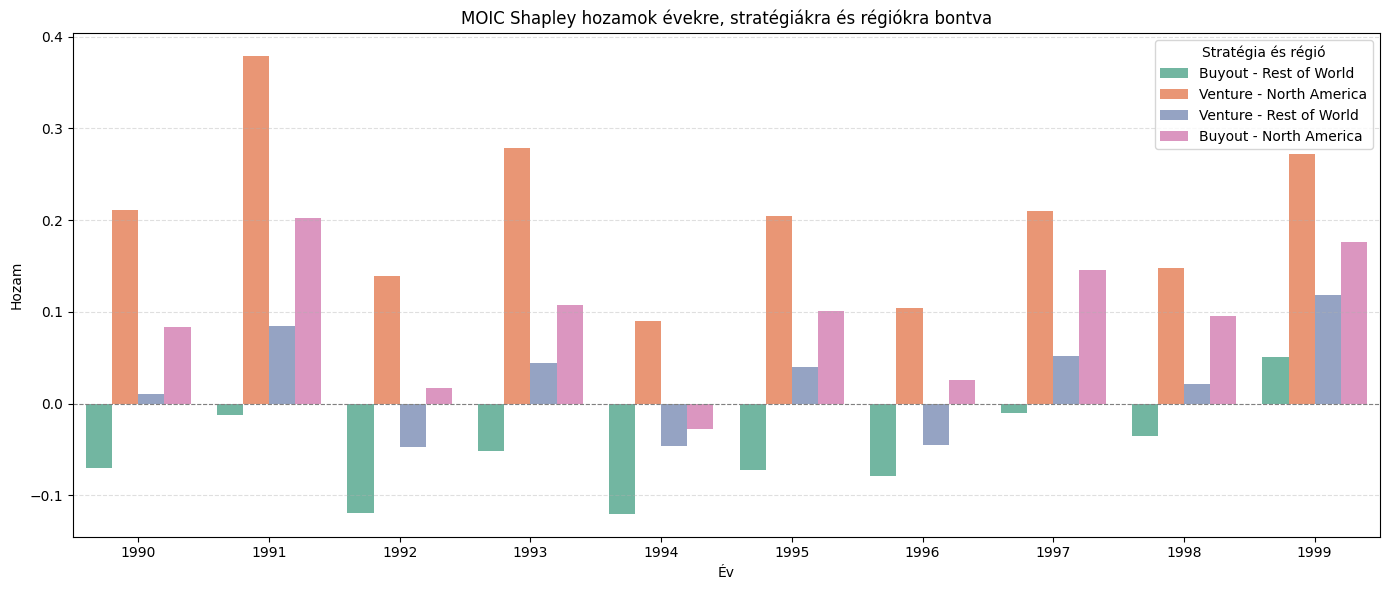

In [291]:
df = pd.DataFrame(
    [(year, strategy, geo, value) for (year, strategy, geo), value in shapley_moic_results_1000.items()],
    columns=["Year", "Strategy", "Geography", "Value"]
)

# Combine Strategy and Geography for clearer bar groups
df["Group"] = df["Strategy"] + " - " + df["Geography"]

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df, x="Year", y="Value", hue="Group", palette="Set2")  # No edgecolor = no black lines

plt.title("MOIC Shapley hozamok évekre, stratégiákra és régiókra bontva")
plt.xlabel("Év")
plt.ylabel("Hozam")
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.legend(title="Stratégia és régió")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.savefig("moic_shapley_ind.pdf", format='pdf', bbox_inches='tight')

plt.show()

In [33]:
# plt.bar(range(len(shapley_moic_results)), shapley_moic_results.values(), color='blue', alpha=0.7, edgecolor='black')
# plt.show()

### Statistics for the residuals

In [217]:
s_moic_50 = pd.Series(moic_residual_500)
print(s_moic_50.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean        0.001467
std         0.236566
min        -0.639182
5%         -0.381601
25%        -0.163198
50%        -0.002561
75%         0.165340
95%         0.398302
max         0.706040
dtype: float64


In [218]:
s_moic_100 =pd.Series(moic_residual_1000)
print(s_moic_100.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean       -0.001261
std         0.239893
min        -0.697222
5%         -0.389306
25%        -0.167840
50%        -0.005744
75%         0.161027
95%         0.417557
max         0.696277
dtype: float64


In [261]:
s_irr_50 = pd.Series(irr_residual_500)
print(s_irr_50.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean       -0.000143
std         0.013224
min        -0.038284
5%         -0.021730
25%        -0.009087
50%         0.000050
75%         0.008780
95%         0.021740
max         0.043294
dtype: float64


In [262]:
s_irr_100 = pd.Series(irr_residual_1000)
print(s_irr_100.describe(percentiles=[.05, .25, .5, .75, .95]))

count    1000.000000
mean        0.000091
std         0.013438
min        -0.043552
5%         -0.022012
25%        -0.008984
50%         0.000029
75%         0.009074
95%         0.021784
max         0.044170
dtype: float64


### Individual effects

In [187]:
# Convert to DataFrame
df = pd.DataFrame(
    [(year, strategy, geo, value) for (year, strategy, geo), value in shapley_irr_results_100.items()],
    columns=["Year", "Strategy", "Geography", "Value"]
)
summary = df.groupby(["Geography"])['Value'].sum()
summary

Geography
North America    0.141809
Rest of World   -0.046019
Name: Value, dtype: float64

### Market approximation

In [263]:
def shapley_simulation_with_wdf(cashflows, shapley_irr_results, type, num_simulations=10, portfolio_size=200):
    results = []
    
    for _ in range(num_simulations):
        # Generate a random portfolio
        portfolio = portfolio_cashflows(cashflows, portfolio_size)
        
        # Calculate the attribution weights for the portfolio
        weights_df = calculate_attribution_weights(portfolio[portfolio['Cashflow'] < 0])
        
        # Calculate the weighted attribution results
        weighted_results = weighted_attribution(weights_df, shapley_irr_results)
        # Calculate the portfolio return
        if type == 'irr':
            port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
            port_return = xirr(port_aggregated_df['date'], port_aggregated_df['Cashflow'])
        elif type == 'moic':
            port_aggregated_df = portfolio.groupby('date', as_index=False)['Cashflow'].sum()
            port_return = moic(port_aggregated_df)
        
        # Store the results
        results.append([weighted_results ,sum(weighted_results.values())*len(shapley_irr_results), port_return])
    
    return results

In [264]:
wdf = shapley_simulation_with_wdf(cashflows, shapley_irr_results_1000, 'irr', 1, 2400)[0][0]

In [272]:
shapley_simulation_with_wdf(cashflows, shapley_irr_results_1000, 'irr', 1, 2400)[0][1]

0.09485333739553196

In [284]:
print(shapley_simulation_with_wdf(cashflows, shapley_irr_results_1000, 'irr', 1, 2400)[0][1]*100)
print(shapley_simulation_with_wdf(cashflows, shapley_irr_results_1000, 'irr', 1, 2400)[0][2]*100)

9.485333739553196
9.578990132895406


In [268]:
shapley_simulation_with_wdf(cashflows, shapley_irr_results_1000, 'irr', 1, 2400)[0][2]

0.09578990132895406

In [192]:
df = pd.DataFrame(
    [(year, strategy, geo, value) for (year, strategy, geo), value in wdf.items()],
    columns=["Year", "Strategy", "Geography", "Value"]
)
summary_vintage = df.groupby(["Year"])['Value'].sum()*40
summary_strat = df.groupby(["Strategy"])['Value'].sum()*40
summary_geo = df.groupby(["Geography"])['Value'].sum()*40

In [193]:
(summary_geo*40).values.sum()

3.794133495821278

In [194]:
(summary_strat*40).values.sum()

3.7941334958212773

In [195]:
summary_strat*40

Strategy
Buyout     0.039397
Venture    3.754736
Name: Value, dtype: float64

In [84]:
summary_vintage*40

Year
1990   -0.004199
1991    0.030913
1992   -0.006886
1993    0.019769
1994    0.003670
1995    0.017224
1996    0.001069
1997    0.020476
1998   -0.000906
1999    0.014469
Name: Value, dtype: float64

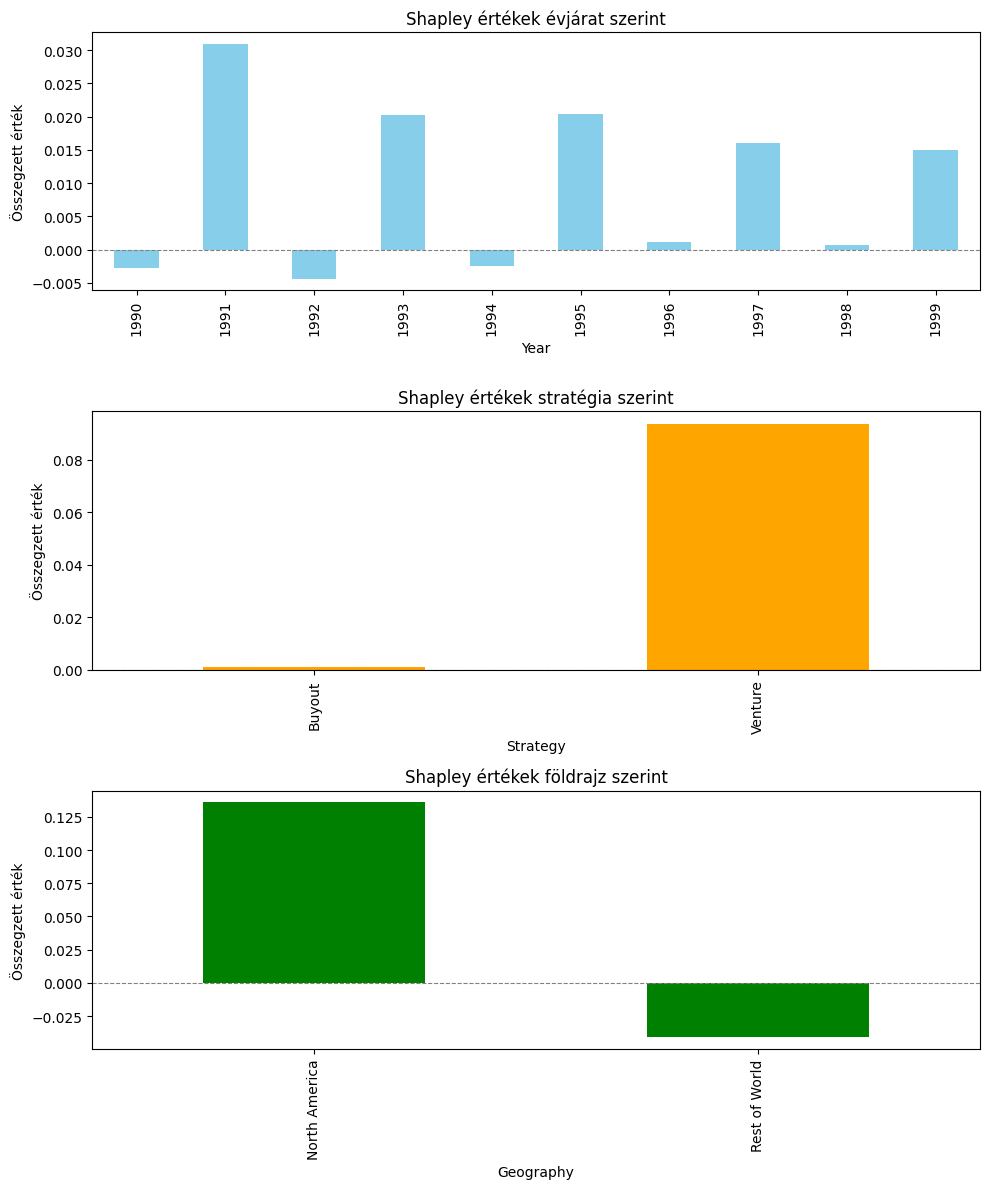

In [196]:
import matplotlib.pyplot as plt

# Set up the figure with 3 subplots
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=False)

# Plot 1: By Year (Vintage)
summary_vintage.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title("Shapley értékek évjárat szerint")
axes[0].set_ylabel("Összegzett érték")
axes[0].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Plot 2: By Strategy
summary_strat.plot(kind='bar', ax=axes[1], color='orange')
axes[1].set_title("Shapley értékek stratégia szerint")
axes[1].set_ylabel("Összegzett érték")
axes[1].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Plot 3: By Geography
summary_geo.plot(kind='bar', ax=axes[2], color='green')
axes[2].set_title("Shapley értékek földrajz szerint")
axes[2].set_ylabel("Összegzett érték")
axes[2].axhline(0, color='gray', linestyle='--', linewidth=0.8)

# Layout adjustment
plt.tight_layout()
plt.show()

### Fitt

In [296]:
moic_result_1000

[[2.6822244928896892, 2.7291167880510865],
 [3.0096013195303546, 2.584314745474841],
 [2.7626093560588707, 2.538379177745516],
 [2.239672767210231, 2.438355259471556],
 [3.013134926032588, 2.987516239844194],
 [3.5302125544156198, 3.047054801706401],
 [2.2150286891624864, 2.639710108616599],
 [1.8677607142694077, 2.292128038113999],
 [2.4162479755675688, 2.5824507497101767],
 [2.932596520904631, 2.9144656868176266],
 [2.447540353325369, 2.5605238662319443],
 [2.8236043960145167, 2.683416485481554],
 [2.561494283802216, 2.541536179683392],
 [2.418819961110498, 2.580047101036615],
 [2.442582150181523, 2.695591887599064],
 [2.3714267533526465, 2.686693184253497],
 [2.8656380648880315, 2.817715532421332],
 [2.7931889018318623, 2.3911640004860217],
 [3.0096970767348283, 2.6846362874234106],
 [2.208030644446264, 2.384016901118303],
 [2.9539579696000366, 2.7371356952053714],
 [2.459430316652022, 2.634630335201768],
 [2.963842024526486, 2.770496458524836],
 [2.586373984971977, 2.54806200449425

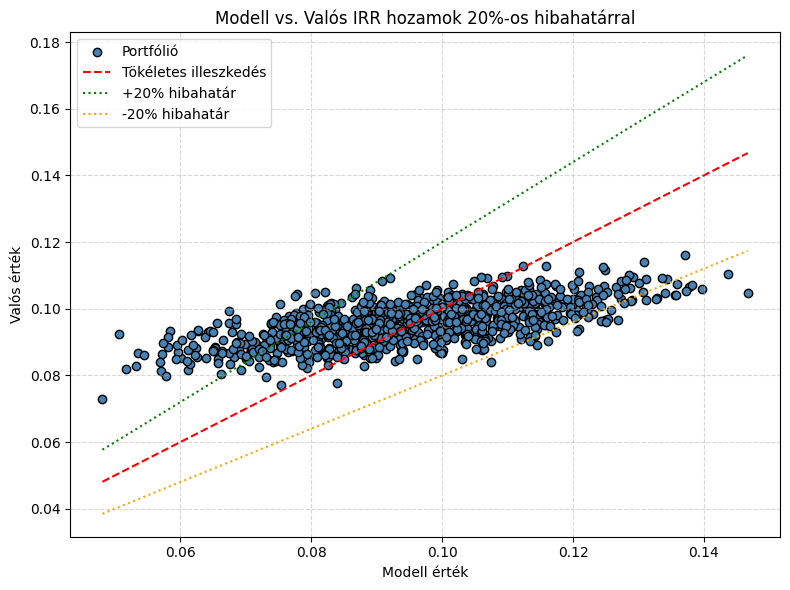

In [315]:

# Szétbontás model és valós értékekre
model, actual = zip(*irr_result_1000)

# Határok kiszámítása
x_vals = sorted(list(model + actual))  # hogy lefedje az összes értéket
min_x, max_x = min(x_vals), max(x_vals)
x_line = [min_x, max_x]

# Ábra létrehozása
plt.figure(figsize=(8, 6))
plt.scatter(model, actual, color='steelblue', edgecolor='black', label='Portfólió')

# Tökéletes illeszkedés
plt.plot(x_line, x_line, color='red', linestyle='--', label='Tökéletes illeszkedés')

# 10%-os hibahatár
plt.plot(x_line, [val * 1.2 for val in x_line], color='green', linestyle=':', label='+20% hibahatár')
plt.plot(x_line, [val * 0.8 for val in x_line], color='orange', linestyle=':', label='-20% hibahatár')

# Címkék, megjelenítés
plt.xlabel('Modell érték')
plt.ylabel('Valós érték')
plt.title('Modell vs. Valós IRR hozamok 20%-os hibahatárral')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("irr_shapley_scatter.pdf", format='pdf', bbox_inches='tight')

plt.show()


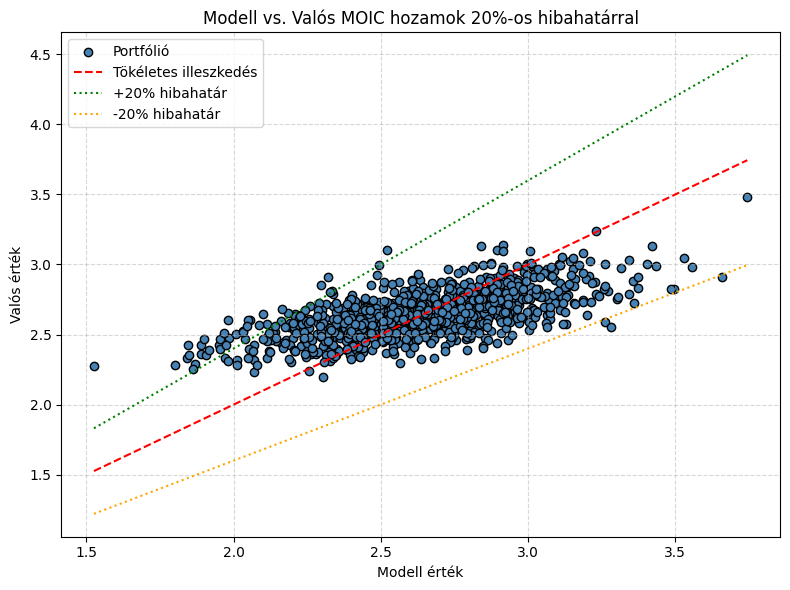

In [316]:

# Szétbontás model és valós értékekre
model, actual = zip(*moic_result_1000)

# Határok kiszámítása
x_vals = sorted(list(model + actual))  # hogy lefedje az összes értéket
min_x, max_x = min(x_vals), max(x_vals)
x_line = [min_x, max_x]

# Ábra létrehozása
plt.figure(figsize=(8, 6))
plt.scatter(model, actual, color='steelblue', edgecolor='black', label='Portfólió')

# Tökéletes illeszkedés
plt.plot(x_line, x_line, color='red', linestyle='--', label='Tökéletes illeszkedés')

# 10%-os hibahatár
plt.plot(x_line, [val * 1.2 for val in x_line], color='green', linestyle=':', label='+20% hibahatár')
plt.plot(x_line, [val * 0.8 for val in x_line], color='orange', linestyle=':', label='-20% hibahatár')

# Címkék, megjelenítés
plt.xlabel('Modell érték')
plt.ylabel('Valós érték')
plt.title('Modell vs. Valós MOIC hozamok 20%-os hibahatárral')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("moic_shapley_scatter.pdf", format='pdf', bbox_inches='tight')

plt.show()


In [314]:

outside_count = sum(
    abs(model - actual) / actual > 0.20
    for model, actual in irr_result_1000
)

total = len(irr_result_1000)
outside_percent = 100 * outside_count / total

print(f"{outside_count} pont ({outside_percent:.1f}%) esik a 20%-os hibahatáron kívül.")


161 pont (16.1%) esik a 20%-os hibahatáron kívül.
